Dashboard für die Fertigung. Zeigt die OEE, Ausschussrate, Variantenverteilung, sowie die Verteilung der Durchlaufzeiten der Varianten

In [ ]:
#Dashboard

import sqlite3
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

# Verbindung zur Datenbank herstellen
db_path = "prod_data.db"
verbindung = sqlite3.connect(db_path)

# Maschinen dynamisch aus der Datenbank abrufen
maschinen_query = "SELECT DISTINCT bmg FROM FLF"
maschinen = pd.read_sql_query(maschinen_query, verbindung)['bmg'].tolist()

# Varianten dynamisch aus der Datenbank abrufen
varianten_query = "SELECT DISTINCT id FROM auftraege"
varianten = pd.read_sql_query(varianten_query, verbindung)['id'].tolist()

# Daten aus der Datenbank abrufen
flf_df = pd.read_sql_query("SELECT * FROM FLF", verbindung)
auftraege_df = pd.read_sql_query("SELECT * FROM auftraege", verbindung)
elf_df = pd.read_sql_query("SELECT * FROM ELF", verbindung)
arbeitsplaene_df = pd.read_sql_query("SELECT * FROM arbeitsplaene",verbindung)

# Daten aufbereiten
flf_df['Charge'] = flf_df['Charge'].astype(str)
auftraege_df['Charge'] = auftraege_df['Charge'].astype(str)

auftraege_df = auftraege_df.merge(flf_df[['Charge', 'bmg']], on='Charge', how='inner')

# Nur relevante Maschinen und Varianten
auftraege_df = auftraege_df[auftraege_df['bmg'].isin(maschinen)]
elf_df = elf_df[elf_df['bmg'].isin(maschinen)]
flf_df = flf_df[flf_df['bmg'].isin(maschinen)]

# Zeitspalten konvertieren
auftraege_df['freigabe'] = pd.to_datetime(auftraege_df['freigabe'], errors='coerce')
auftraege_df['fertigstellung'] = pd.to_datetime(auftraege_df['fertigstellung'], errors='coerce')
elf_df['start_downtime'] = pd.to_datetime(elf_df['start_downtime'], errors='coerce')
elf_df['end_downtime'] = pd.to_datetime(elf_df['end_downtime'], errors='coerce')

# Produktionszeit und Downtime berechnen
auftraege_df['production_time'] = (auftraege_df['fertigstellung'] - auftraege_df['freigabe']).dt.total_seconds().fillna(0)
 # Planzeiten hinzufügen

arbeitsplaene_df['planzeit'] = ((arbeitsplaene_df['r_plan'] + (arbeitsplaene_df['t_plan']*auftraege_df['stueckzahl_plan'])))
planzeit_pro_variante = arbeitsplaene_df.groupby('id')['planzeit'].sum()

# Planzeiten den Aufträgen zuordnen
auftraege_df = auftraege_df.merge(planzeit_pro_variante, on='id', how='left')

print(planzeit_pro_variante)

elf_df['downtime'] = (elf_df['end_downtime'] - elf_df['start_downtime']).dt.total_seconds().fillna(0)

# OEE-Berechnungen
production_time_per_machine = auftraege_df.groupby('bmg')['production_time'].sum()
downtime_per_machine = elf_df.groupby('bmg')['downtime'].sum()
downtime_per_machine = downtime_per_machine.reindex(maschinen, fill_value=0)
availability_per_machine = (production_time_per_machine / (production_time_per_machine + downtime_per_machine)).fillna(0)

flf_df['good_parts'] = flf_df['anzahl_bauteile'] - flf_df['ausschuss']
quality_per_machine = (flf_df.groupby('bmg')['good_parts'].sum() / flf_df.groupby('bmg')['anzahl_bauteile'].sum()).fillna(0)

auftraege_df['cycle_performance'] = auftraege_df['stueckzahl_ist'] / auftraege_df['stueckzahl_plan']
performance_per_machine = auftraege_df.groupby('bmg')['cycle_performance'].mean()

oee_per_machine = (availability_per_machine * performance_per_machine * quality_per_machine).fillna(0)

# Ausschuss berechnen
ausschuss = (flf_df.groupby('bmg')['anzahl_bauteile'].sum() - flf_df.groupby('bmg')['good_parts'].sum())

# Variablen für Tortendiagramme vorbereiten
gesamtstückzahl = auftraege_df['stueckzahl_ist'].sum()
stückzahlen_pro_variante = auftraege_df.groupby('id')['stueckzahl_ist'].sum()
ausschuss_gesamt = flf_df['ausschuss'].sum()
gutteile_gesamt = gesamtstückzahl - ausschuss_gesamt

# --- Dashboard ---
import math

# Gesamtanzahl der Diagramme
total_plots = len(maschinen) + 2  # OEE + Ausschuss + Variantenverteilung + Maschinen-Histogramme

# Anzahl der Zeilen für 2 Spalten
rows = math.ceil(total_plots / 2)

# Neues Subplot-Layout
fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))
fig.tight_layout(pad=5.0)

# Flache Liste der Achsen für einfachere Zuordnung
axs = axs.flatten()

# OEE pro Maschine darstellen
axs[0].bar(oee_per_machine.index, oee_per_machine.values, color='skyblue', edgecolor='black')
for bar in axs[0].patches:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)
axs[0].set_title("OEE pro Maschine")
axs[0].set_xlabel("Maschine")
axs[0].set_ylabel("OEE (%)")
axs[0].set_ylim(0, 1)

# Tortendiagramm: Verteilung der Varianten
axs[1].pie(stückzahlen_pro_variante, labels=stückzahlen_pro_variante.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title("Verteilung der gefertigten Varianten")

# Tortendiagramm: Ausschussrate
axs[2].pie([gutteile_gesamt, ausschuss_gesamt], labels=['Gutteile', 'Ausschuss'], autopct='%1.1f%%', startangle=90)
axs[2].set_title("Ausschussrate")

# Histogramme für Durchlaufzeiten (Maschinen-spezifisch)
for idx, variante in enumerate(varianten):
    variante_data = auftraege_df[auftraege_df['id'] == variante]
    if idx + 3 < len(axs):  # Verhindern, dass wir außerhalb des Achsenbereichs schreiben
        # Durchlaufzeit in Minuten umrechnen
        production_time_minutes = variante_data['production_time'] / 60
        axs[idx + 3].hist(production_time_minutes, bins=50, color='blue', edgecolor='black', alpha=0.7, label='Ist-Zeit')

        # Planzeit-Linie hinzufügen (optional)
        if not variante_data['planzeit'].isna().all():  # Sicherstellen, dass es Planzeiten gibt
            planzeit_mean_minutes = variante_data['planzeit'].mean()   # Planzeit in Minuten
            axs[idx + 3].axvline(planzeit_mean_minutes, color='orange', alpha=0.7, label='Planzeit')
        
        axs[idx + 3].set_title(f"Durchlaufzeit Verteilung für Variante {variante}")
        axs[idx + 3].set_xlabel("Durchlaufzeit (Minuten)")  # Achsentitel angepasst
        axs[idx + 3].set_ylabel("Anzahl")
        axs[idx + 3].legend()


# Entfernen von leeren Subplots
for i in range(total_plots, len(axs)):
    fig.delaxes(axs[i])

# Diagramme anzeigen
plt.show()



Durchlaufdiagramm für die gesamte Fertigung 

In [ ]:
#Durchlaufdiagramm für die gesamte Fertigung

import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
import scipy


#Menge an geplotten Daten
laenge = 10000

#Verschiebeung von Abgangskurve nach hinten um Stunden
h = 0

# Verbindung zur Datenbank herstellen
verbindung = sqlite3.connect("prod_data.db")
zeiger = verbindung.cursor()


def berechne_betriebs_stunden(zeitpunkt, start_datum):
    """Berechnet die Betriebsstunden seit dem ersten Produktionstag"""
    return (zeitpunkt - start_datum).total_seconds() / 3600  # Umrechnung von Sekunden in Stunden

zeiger.execute(f"SELECT freigabe, fertigstellung, stueckzahl_plan, stueckzahl_ist FROM auftraege WHERE fertigstellung IS NOT NULL ORDER BY freigabe ASC")
daten = zeiger.fetchall()
    

# Umwandeln der Daten in datetime-Objekte und sicherstellen, dass keine None-Werte enthalten sind
ankunft_liste = []
fertigstellung_liste = []
vorgabe_liste = []
real_liste = []
    
for e in daten:
    # Wenn die Werte nicht None sind, führe das Parsing durch
    if e[0] is not None and e[1] is not None:
        ankunft_liste.append(datetime.strptime(e[0], '%Y-%m-%d %H:%M:%S'))
        fertigstellung_liste.append(datetime.strptime(e[1], '%Y-%m-%d %H:%M:%S'))
        vorgabe_liste.append(int(e[2]))  
        real_liste.append(int(e[3]))# Vorgabe ist der Arbeitsinhalt

fertigstellung_liste = [e + timedelta(hours=h) for e in fertigstellung_liste]
    
# Prüfen, ob die Listen leer sind, bevor wir mit min() fortfahren
if not ankunft_liste:
    print(f"Keine gültigen Startzeiten für Maschine gefunden.")
    
# Berechnen des ersten Produktionsdatums
start_datum = min(ankunft_liste)
    
# Berechnen der Betriebsstunden für Zugang und Abgang
zugang_stunden = [berechne_betriebs_stunden(e, start_datum) for e in ankunft_liste]
abgang_stunden = [berechne_betriebs_stunden(e, start_datum) for e in fertigstellung_liste]
    
# Kumulative Summe für die Zugangskurve und Abgangskurve
kumulierte_zugang = [sum(vorgabe_liste[:i+1]) for i in range(len(vorgabe_liste))]
kumulierte_abgang = [sum(real_liste[:i+1]) for i in range(len(real_liste))]

#lineare Regression für beide Kurven 

X_zugang = np.array(zugang_stunden).reshape(-1, 1)
y_zugang = np.array(kumulierte_zugang)

X_abgang = np.array(abgang_stunden).reshape(-1, 1)
y_abgang = np.array(kumulierte_abgang)

model_zugang = LinearRegression().fit(X_zugang, y_zugang)
zugang_prognose = model_zugang.predict(X_zugang)

model_abgang = LinearRegression().fit(X_abgang, y_abgang)
abgang_prognose = model_abgang.predict(X_abgang)

bestand = [kumulierte_zugang[i] - kumulierte_abgang[i] for i in range(len(kumulierte_zugang))]

#debugging


#print(kumulierte_zugang_interp[0])

P = max(abgang_stunden) - min(zugang_stunden)  # Bezugzeitraum in Stunden
Bm = sum(vorgabe_liste) / len(vorgabe_liste)  # Durchschnittlicher Bestand
Rm = Bm / (P / len(zugang_stunden))  # Mittlere Reichweite
Lm = kumulierte_abgang[-1] / P  # Mittlere Leistung

#zugang_stunden_multipliziert = [Lm * z for z in zugang_stunden]
 #abgang_stunden_multipliziert = [Lm * a for a in abgang_stunden]

# Alternativ mit numpy
zugang_stunden_multipliziert = np.array(zugang_stunden) * Lm
abgang_stunden_multipliziert = np.array(abgang_stunden) * Lm
  

#y = Lm * zugang_stunden

# Visualisierung des Diagramms für die Maschine
fig, ax = plt.subplots(figsize=(10, 6))
    
# Zugangskurve (blau)
ax.step(zugang_stunden[:laenge], kumulierte_zugang[:laenge], label='Zugangskurve', color='blue', where='mid')
#ax.plot(zugang_stunden[:laenge], zugang_stunden_multipliziert[:laenge], color = 'gray', linestyle='--')
ax.plot(zugang_stunden[:laenge], zugang_prognose[:laenge], color='grey', linestyle='dashdot')
    
# Abgangskurve (rot)
ax.step(abgang_stunden[:laenge], kumulierte_abgang[:laenge], label='Abgangskurve', color='red', where='mid')
#ax.plot(abgang_stunden[:laenge], abgang_stunden_multipliziert[:laenge],color = 'gray')
ax.plot(abgang_stunden[:laenge], abgang_prognose[:laenge],color='grey', linestyle='dashdot')

# Mittlerer Bestand als schattierte Fläche zwischen Zugang und Abgang
ax.fill_between(zugang_stunden[:laenge],kumulierte_zugang[:laenge], color='grey', step='mid', alpha=0.7, label='Bestandsfläche FB')
ax.fill_between(abgang_stunden[:laenge], kumulierte_abgang[:laenge], color='white', step='mid',interpolate= False, alpha=1)

    
# Linien für die mittleren Werte
ax.axhline(Bm, color='green', linestyle='--', label=f'Mittlerer Bestand Bm = {Bm:.2f}')
ax.axhline(Lm, color='purple', linestyle='--', label=f'Mittlere Leistung Lm = {Lm:.2f}')
ax.axvline(Rm, color='orange', linestyle='--', label=f'Mittlere Reichweite Rm = {Rm:.2f}')
    
    # Diagrammdetails
ax.set_xlabel("Betriebsstunden")
ax.set_ylabel("Kumulierte Arbeitsinhalte in Stk.")
ax.set_title(f"Durchlaufdiagramm für Maschine")
ax.legend(loc='upper left')
ax.grid(True)

# Layout anpassen und Diagramm anzeigen
plt.tight_layout()
plt.show()

# Verbindung zur Datenbank schließen
verbindung.close()


#Mittlerer Bestand und andere Kennwerte anschauen 

Durchlaufdiagramme für jede einzelne (produzierende) Maschine. Hier muss man jedes Diagramm wieder einzeln schließen damit das nächste erscheint

In [ ]:

import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math


#Menge an geplotten Daten
laenge = 170

#Verschiebeung von Abgangskurve nach hinten um Stunden
h = 0

# Verbindung zur Datenbank herstellen
verbindung = sqlite3.connect("prod_data.db")
zeiger = verbindung.cursor()

# Abrufen der Maschinen aus der Datenbank
zeiger.execute("SELECT DISTINCT bmg FROM FLF")
maschinen = zeiger.fetchall()

# Funktion zur Berechnung der Betriebsstunden in Stunden seit dem ersten Produktionstag
def berechne_betriebs_stunden(zeitpunkt, start_datum):
    """Berechnet die Betriebsstunden seit dem ersten Produktionstag"""
    return (zeitpunkt - start_datum).total_seconds() / 3600  # Umrechnung von Sekunden in Stunden

# Erstellen eines Diagramms für jede Maschine
for maschine in maschinen:
    maschine_name = maschine[0]
    
    # Daten für die aktuelle Maschine holen
    zeiger.execute(f"SELECT ankunft, ende_bearbeitung, anzahl_bauteile, anzahl_bauteile + ausschuss AS plan FROM FLF WHERE bmg = '{maschine_name}'")
    daten = zeiger.fetchall()
    
    # Umwandeln der Daten in datetime-Objekte und sicherstellen, dass keine None-Werte enthalten sind
    ankunft_liste = []
    fertigstellung_liste = []
    vorgabe_liste = []
    real_liste = []
    
    for e in daten:
        # Wenn die Werte nicht None sind, führe das Parsing durch
        if e[0] is not None and e[1] is not None:
            ankunft_liste.append(datetime.strptime(e[0], '%Y-%m-%d %H:%M:%S'))
            fertigstellung_liste.append(datetime.strptime(e[1], '%Y-%m-%d %H:%M:%S'))
            vorgabe_liste.append(int(e[3])) 
            real_liste.append(int(e[2])) # Vorgabe ist der Arbeitsinhalt

    #verschieben der Abgangskurve um 4 Stunden nach hinten zur besseren Visualiesierung 
    fertigstellung_liste = [e + timedelta(hours=h) for e in fertigstellung_liste]
    
    # Prüfen, ob die Listen leer sind, bevor wir mit min() fortfahren
    if not ankunft_liste:
        print(f"Keine gültigen Startzeiten für Maschine {maschine_name} gefunden.")
        continue
    
    # Berechnen des ersten Produktionsdatums
    start_datum = min(ankunft_liste)
    
    # Berechnen der Betriebsstunden für Zugang und Abgang
    zugang_stunden = [berechne_betriebs_stunden(e, start_datum) for e in ankunft_liste]
    abgang_stunden = [berechne_betriebs_stunden(e, start_datum) for e in fertigstellung_liste]
    
    # Kumulative Summe für die Zugangskurve und Abgangskurve
    kumulierte_zugang = [sum(vorgabe_liste[:i+1]) for i in range(len(vorgabe_liste))]
    kumulierte_abgang = [sum(real_liste[:i+1]) for i in range(len(real_liste))]


    import numpy as np

    # Gemeinsame x-Werte für Zugang und Abgang finden
    gemeinsame_x = np.union1d(zugang_stunden, abgang_stunden)

    # Interpolierte y-Werte für kumulierte Zugang und Abgang
    kumulierte_zugang_interp = np.interp(gemeinsame_x, zugang_stunden, kumulierte_zugang)
    kumulierte_abgang_interp = np.interp(gemeinsame_x, abgang_stunden, kumulierte_abgang)



    #print(ankunft_liste)
    #print(fertigstellung_liste)
    #print (start_datum)
    #print(kumulierte_zugang)
    #print(zugang_stunden)
    #print(kumulierte_abgang)
    #print(kumulierte_abgang_interp)
    #print(kumulierte_zugang_interp)



    # Berechnung der mittleren Größen
    P = max(abgang_stunden) - min(zugang_stunden)  # Bezugzeitraum in Stunden
    Bm = sum(vorgabe_liste) / len(vorgabe_liste)  # Durchschnittlicher Bestand
    Rm = Bm / (P / len(zugang_stunden))  # Mittlere Reichweite
    Lm = kumulierte_abgang[-1] / P  # Mittlere Leistung



  

    #y = Lm * zugang_stunden

    # Visualisierung des Diagramms für die Maschine
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Zugangskurve (blau)
    ax.step(zugang_stunden[:laenge], kumulierte_zugang[:laenge], label='Zugangskurve', color='blue', where='mid')
    
    
    # Abgangskurve (rot)
    ax.step(abgang_stunden[:laenge], kumulierte_abgang[:laenge], label='Abgangskurve', color='red', where='mid')
    #ax.plot(abgang_stunden[:laenge], abgang_stunden_multipliziert[:laenge],color = 'gray')

    # Mittlerer Bestand als schattierte Fläche zwischen Zugang und Abgang
    ax.fill_between(zugang_stunden[:laenge], kumulierte_zugang[:laenge], color='grey', step='mid', alpha=0.7, label='Bestandsfläche FB')
    ax.fill_between(abgang_stunden[:laenge], kumulierte_abgang[:laenge], color='white', step='mid',interpolate= False, alpha=1)
    
    
    # Linien für die mittleren Werte
    ax.axhline(Bm, color='green', linestyle='--', label=f'Mittlerer Bestand Bm = {Bm:.2f}')
    ax.axhline(Lm, color='purple', linestyle='--', label=f'Mittlere Leistung Lm = {Lm:.2f}')
    ax.axvline(Rm, color='orange', linestyle='--', label=f'Mittlere Reichweite Rm = {Rm:.2f}')
    
    # Diagrammdetails
    ax.set_xlabel("Betriebsstunden")
    ax.set_ylabel("Kumulierte Arbeitsinhalte in Stk.")
    ax.set_title(f"Durchlaufdiagramm für Maschine {maschine_name}")
    ax.legend(loc='upper left')
    ax.grid(True)

    # Layout anpassen und Diagramm anzeigen
    plt.tight_layout()
    plt.show()

# Verbindung zur Datenbank schließen
verbindung.close()

#Für gesamte Fertigung Freigabeauftrag und Fertigstellung 
#Wenn pro Maschine dann auch Lagermenge davor betrachten 
#ohne Downtimes (Schichtende, Wochenende)



#Funktion mit Angabe Start- und Enddatum 
#Diagramme für Maschinen --> Welcher Aufträge waren auf welchen Maschinen 
#Wie Plantafel für Fertigung 

Plantafel für die Fertigung ohne Stillstandzeiten 

/var/folders/bd/4skfjjdn4dv6rl49dh8758200000gn/T/ipykernel_8228/3192698401.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', len(unique_charges))


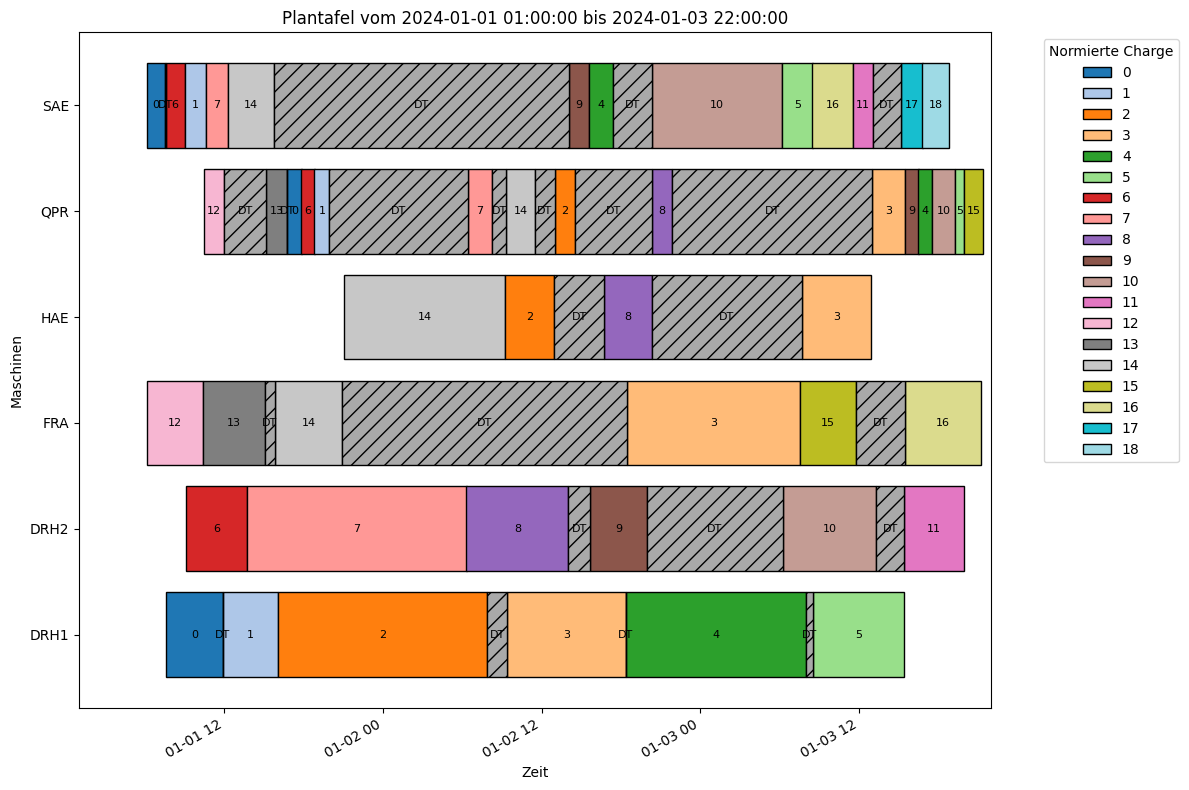

In [7]:
#Plantafel für die Fertigung (ohne Stillstandszeiten)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import matplotlib.patches as patches
import datetime
import sqlite3

#Hier gewünschten Beobachtungszeitraum definieren 
start_vor = "2024-01-01 01:00:00"
ende_vor = "2024-01-03 22:00:00"



# Verbindung zur Datenbank wiederherstellen
conn = sqlite3.connect("prod_data.db")

# Daten aus den relevanten Tabellen abrufen
auftraege_query = """
SELECT a.Charge, a.start_ruesten, a.abtransport, a.bmg
FROM FLF AS a
"""
auftraege_data = pd.read_sql_query(auftraege_query, conn)

# Konvertierung der Zeitstempel in Datetime-Objekte
auftraege_data['start_ruesten'] = pd.to_datetime(auftraege_data['start_ruesten'])
auftraege_data['abtransport'] = pd.to_datetime(auftraege_data['abtransport'])

# Schließen der Verbindung zur Datenbank
conn.close()

#Debugging

#print(auftraege_data)

# Funktion zur Erstellung der Plantafel
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def Plantafel(start_date, end_date, data):
    # Filterung der Daten basierend auf dem gegebenen Zeitraum
    filtered_data = data[
        (data['start_ruesten'] >= pd.Timestamp(start_date)) &
        (data['abtransport'] <= pd.Timestamp(end_date))
    ]
    
    # Sortieren der Daten nach Maschinen und Startzeit
    filtered_data = filtered_data.sort_values(by=['bmg', 'start_ruesten'])
    
    # Normierung der Chargen
    unique_charges = filtered_data['Charge'].unique()
    charge_mapping = {charge: idx for idx, charge in enumerate(unique_charges)}
    filtered_data['Charge_norm'] = filtered_data['Charge'].map(charge_mapping)
    
    # Farben für verschiedene Chargen definieren
    color_map = cm.get_cmap('tab20', len(unique_charges))
    charge_colors = {idx: mcolors.rgb2hex(color_map(i)) for i, idx in enumerate(charge_mapping.values())}
    
    # Berechnung der Stillstandszeiten
    idle_times = []
    for machine, group in filtered_data.groupby('bmg'):
        group = group.sort_values('start_ruesten')
        for i in range(len(group) - 1):
            current_end = group.iloc[i]['abtransport']
            next_start = group.iloc[i + 1]['start_ruesten']
            if current_end < next_start:  # Es gibt eine Lücke
                idle_times.append({
                    'bmg': machine,
                    'start_idle': current_end,
                    'end_idle': next_start
                })
    
    # Gantt-Diagramm erstellen
    fig, ax = plt.subplots(figsize=(12, 8))
    for i, row in filtered_data.iterrows():
        start = row['start_ruesten']
        end = row['abtransport']
        color = charge_colors[row['Charge_norm']]
        ax.barh(row['bmg'], date2num(end) - date2num(start), left=date2num(start),
                color=color, edgecolor='black', label=row['Charge_norm'] if row['Charge_norm'] not in ax.get_legend_handles_labels()[1] else "")
        # Normierte Charge in der Mitte der Balken hinzufügen
        ax.text(date2num(start) + (date2num(end) - date2num(start)) / 2, 
                row['bmg'],  # Vertikale Position basierend auf 'bmg'
                str(row['Charge_norm']), 
                ha='center', va='center', fontsize=8, color='black')
    
    # Stillstandszeiten hinzufügen (mit Schraffur)
    for idle in idle_times:
        start_idle = idle['start_idle']
        end_idle = idle['end_idle']
        ax.barh(idle['bmg'], date2num(end_idle) - date2num(start_idle), left=date2num(start_idle),
                color='darkgray', edgecolor='black', hatch='//', alpha=1)
        ax.text(date2num(start_idle) + (date2num(end_idle) - date2num(start_idle)) / 2, 
                idle['bmg'],  # Vertikale Position basierend auf 'bmg'
                'DT', 
                ha='center', va='center', fontsize=8, color='black')
    
    # Achsen und Titel anpassen
    ax.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Maschinen")
    ax.set_title(f"Plantafel vom {start_date} bis {end_date}")
    ax.xaxis_date()
    fig.autofmt_xdate()
    
    # Legende hinzufügen
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Normierte Charge", loc='upper left', bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    plt.show()

# Aufrauf der Funktion
Plantafel(start_vor, ende_vor, auftraege_data)

